LSTM (Long short-term memory) model


# %% md
# LSTM Model for Volatility Analysis with Diagnostic Residual Plots and Event Study
#
# This notebook downloads historical stock data for a selection of S&P 500 stocks,
# computes a rolling volatility measure, adds a dummy earnings flag, prepares sequences
# for an LSTM model, trains the model to predict next-day volatility, and generates both
# diagnostic residual plots as well as an event study around earnings dates.

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from io import StringIO
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Download Stock Data
# -------------------------------
# Scrape the S&P 500 tickers from Wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(wiki_url)
wiki_tables = pd.read_html(StringIO(response.text))
sp500_table = wiki_tables[0]
ticker_list = sp500_table["Symbol"].tolist()

# Convert tickers to Yahoo Finance format (replace dots with dashes) and limit for testing
ticker_list = [ticker.replace(".", "-") for ticker in ticker_list][:50]

# Define date range for historical data (a 5-year window)
start_date = "2020-01-01"
end_date = "2025-01-01"


def get_stock_data(ticker, start_date=start_date, end_date=end_date):
    """
    Fetch historical stock data for a ticker using yfinance.
    """
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()


# Download and accumulate data for each ticker
all_stock_data = []
for ticker in tqdm(ticker_list, desc="Downloading stock data"):
    df = get_stock_data(ticker)
    if not df.empty and not df.isna().all().all():
        df["Ticker"] = ticker
        all_stock_data.append(df)
    time.sleep(1)  # Avoid hitting rate limits

if all_stock_data:
    final_df = pd.concat(all_stock_data, ignore_index=False)
    print(f"Collected data for {len(all_stock_data)} stocks")
else:
    print("No stock data was collected.")

Collected data for 50 stocks


In [7]:
# %% md
# 2. Data Preparation for a Selected Stock
#
# For this example, we will work with the first ticker from our list.

In [8]:
# %% code
# Filter data for a single ticker (first in the list)
selected_ticker = ticker_list[0]
df_model = final_df[final_df["Ticker"] == selected_ticker].sort_index()

# Compute daily returns and a 5-day rolling volatility (using standard deviation)
df_model["Return"] = df_model["Close"].pct_change()
df_model["Volatility"] = df_model["Return"].rolling(window=5).std()

# -------------------------------
# 3. Incorporate Earnings Information
# -------------------------------
# Define a list of dummy earnings dates; replace these with actual dates as needed.
earnings_dates = pd.to_datetime(["2023-01-25", "2023-04-25", "2023-07-25", "2023-10-25"])

# Create an earnings flag (1 for earnings day, 0 otherwise)
df_model["Earnings_Flag"] = df_model.index.isin(earnings_dates).astype(int)

# Remove the initial rows where volatility is NaN due to the rolling computation
df_model = df_model.dropna(subset=["Volatility"])

In [9]:
# %% md
# 4. Create Feature Sequences for the LSTM Model
#
# We will use two features: the rolling volatility and the earnings flag.
# A dedicated scaler is used for volatility so we can later invert the scaling.

In [21]:
# %% code
from sklearn.preprocessing import MinMaxScaler

# Scale the volatility between 0 and 1 using a dedicated scaler
vol_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vol = vol_scaler.fit_transform(df_model[["Volatility"]])

# Keep the earnings flag as is (convert to float)
earnings_flag = df_model[["Earnings_Flag"]].values.astype(float)

# Combine the features side by side
features_array = np.concatenate([scaled_vol, earnings_flag], axis=1)


def create_feature_sequences(data, window_size=60):
    """
    Create sequences of data for LSTM.

    Args:
        data (np.array): Array of features.
        window_size (int): Number of time steps per sample.

    Returns:
        X (np.array): Feature sequences.
        y (np.array): Next-day volatility values.
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size: i])
        y.append(data[i, 0])  # Next-day volatility (scaled)
    return np.array(X), np.array(y)


window_size = 180  # Number of past days to use for prediction
X_all, y_all = create_feature_sequences(features_array, window_size)
print("Shape of feature sequences (X):", X_all.shape)
print("Shape of target values (y):", y_all.shape)

Shape of feature sequences (X): (1073, 180, 2)
Shape of target values (y): (1073,)


In [22]:
# %% md
# 5. Split the Data into Training and Test Sets

In [24]:
# %% code
# Use an 80-20 split for training and testing
split_index = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

In [25]:
# %% md
# 6. Build and Train the LSTM Model

In [28]:
# %% code
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100


/Users/anish/STUDY/Spring 25/F. Data Science/Stock-Volatility/.venv1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0084 - val_loss: 0.0107
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0038 - val_loss: 0.0096
Epoch 4/100
 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0042

KeyboardInterrupt: 

In [29]:
# %% md
# 7. Generate Predictions and Inverse-Scale Them

In [30]:
# %% code
# Generate predictions on the test set
predictions = model.predict(X_test)

# Inverse transform predictions
predictions_inv = vol_scaler.inverse_transform(predictions)
y_test_inv = vol_scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [31]:
# %% md
# 8. Diagnostic Residual Plots
#
# The following plots are used to diagnose model performance by examining the residuals.

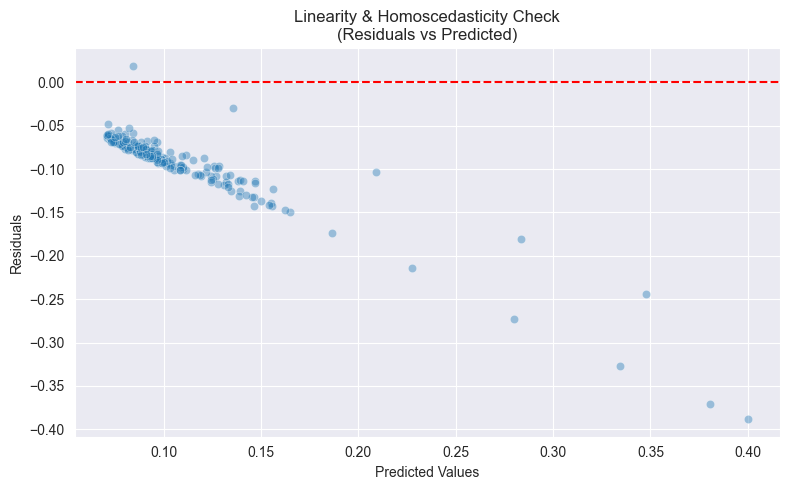

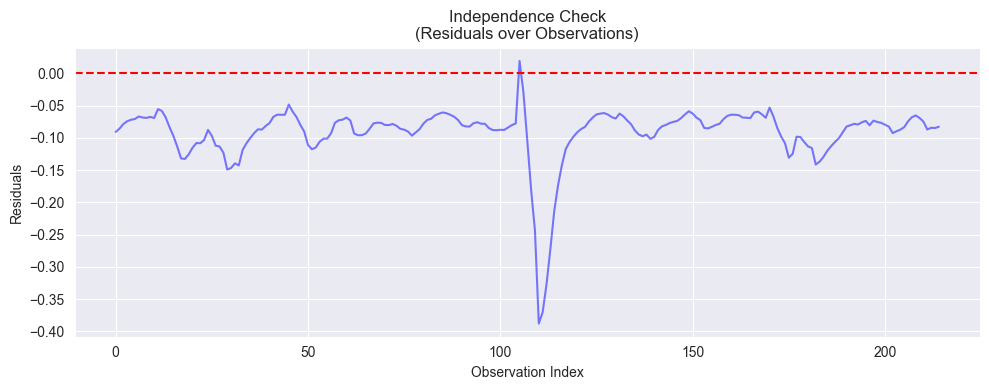

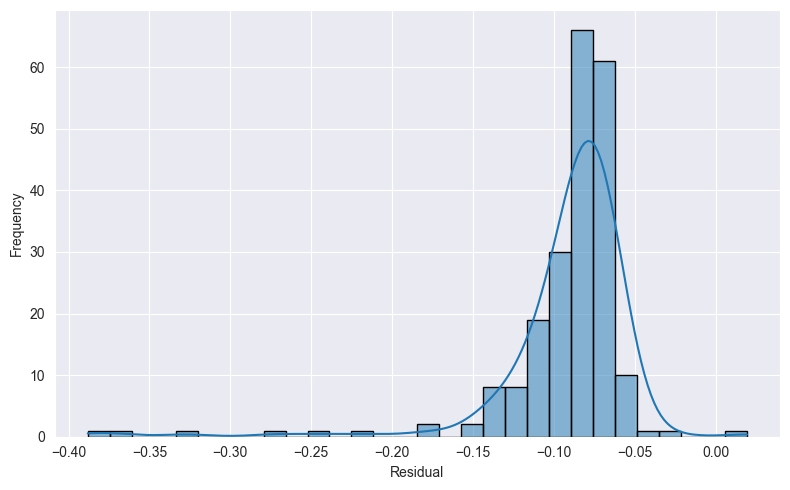

In [32]:
# %% code
# Define y_pred and calculate residuals for diagnostics
y_pred = predictions  # For clarity, assign predictions to y_pred
residuals = y_test_inv.flatten() - y_pred.flatten()

# 1. Linearity & Homoscedasticity Check (Residuals vs Predicted)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred.flatten(), y=residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Linearity & Homoscedasticity Check\n(Residuals vs Predicted)")
plt.tight_layout()
plt.show()

# 2. Independence Check (Residuals over Observations)
plt.figure(figsize=(10, 4))
plt.plot(residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.title("Independence Check\n(Residuals over Observations)")
plt.tight_layout()
plt.show()

# 3. Normality Check - Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [33]:
# %% md
# 9. Event Study: Volatility Around Earnings Dates
#
# The following code generates predictions over the full dataset (starting from the initial window)
# and then examines the actual and predicted volatility in an event window around each earnings date.

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


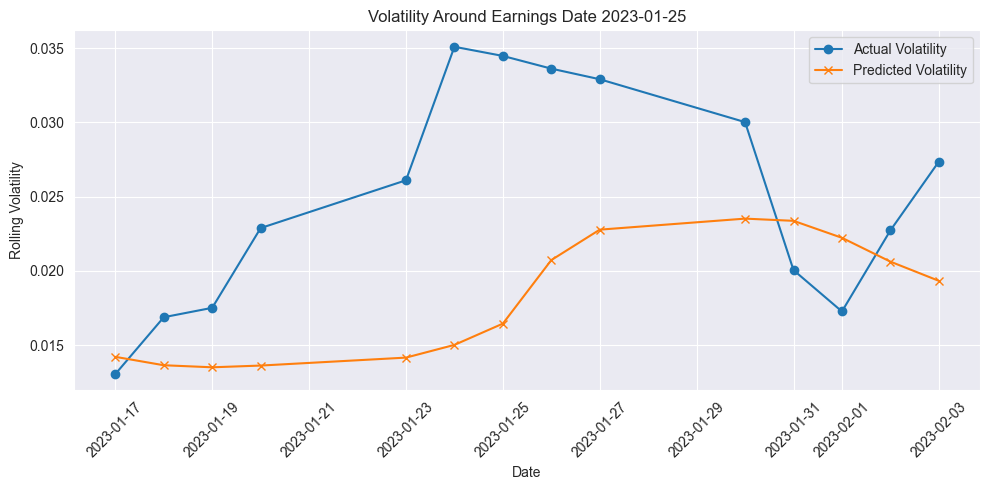

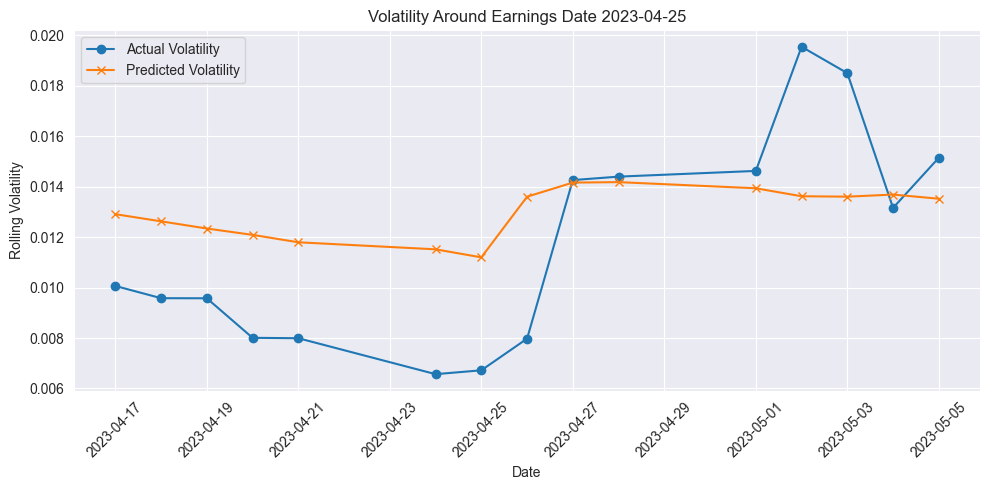

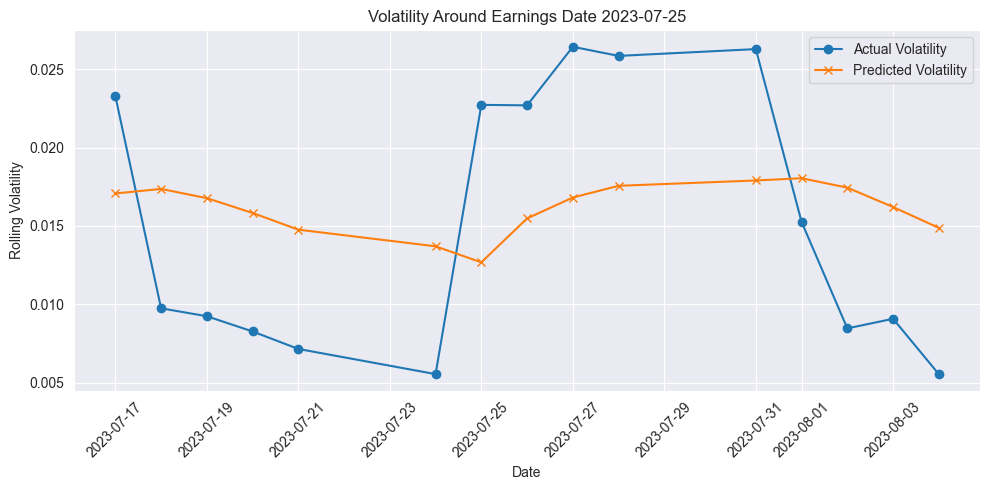

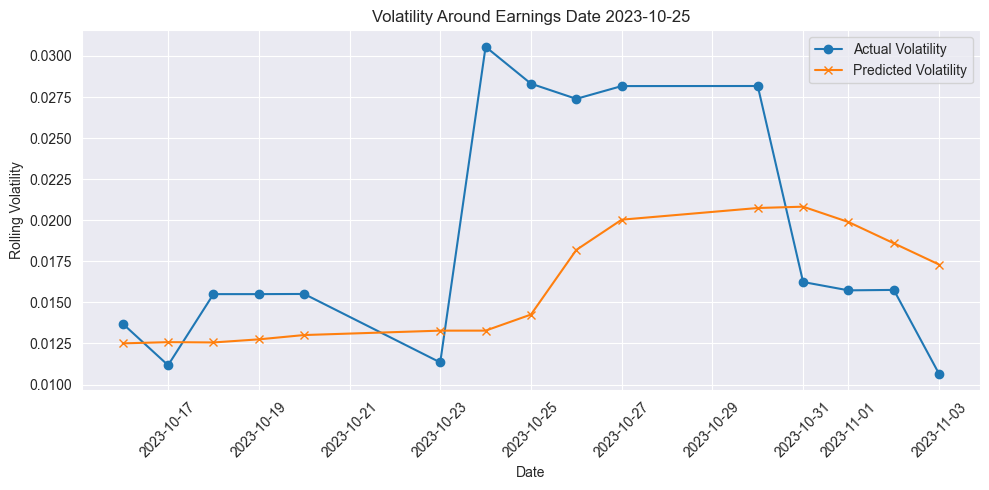

In [34]:
# %% code
# Generate predictions for the complete dataset
predicted_vol_full = model.predict(X_all)
predicted_vol_full = vol_scaler.inverse_transform(predicted_vol_full)

# Align predictions with the DataFrame (skip the first window_size days)
df_model_event = df_model.iloc[window_size:].copy()
df_model_event["Predicted_Volatility"] = predicted_vol_full

event_window = 10  # Days before and after each earnings date

for edate in earnings_dates:
    # Define the event window around the earnings date
    start_window = edate - pd.Timedelta(days=event_window)
    end_window = edate + pd.Timedelta(days=event_window)

    # Extract actual and predicted volatility within this window
    window_actual = df_model_event.loc[start_window:end_window]["Volatility"]
    window_pred = df_model_event.loc[start_window:end_window]["Predicted_Volatility"]

    plt.figure(figsize=(10, 5))
    plt.plot(window_actual.index, window_actual, marker="o", label="Actual Volatility")
    plt.plot(window_pred.index, window_pred, marker="x", label="Predicted Volatility")
    plt.title(f"Volatility Around Earnings Date {edate.strftime('%Y-%m-%d')}")
    plt.xlabel("Date")
    plt.ylabel("Rolling Volatility")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()